In [1]:
from top2vec.Top2Vec import Top2Vec
from top2vec.similarity import (
    describe_closest_items,
    find_closest_items,
    generate_similarity_matrix,
    generate_csr_similarity_matrix,
)
import gensim
from sklearn.datasets import fetch_20newsgroups
import numpy as np

In [5]:
# get 20 newsgroups data
newsgroups_train = fetch_20newsgroups(
    subset="all", remove=("headers", "footers", "quotes")
)
# newsgroups_documents = newsgroups_train.data[0:2000]
newsgroups_documents = newsgroups_train.data

# train top2vec model with doc_ids provided
doc_ids = [str(num) for num in range(0, len(newsgroups_documents))]
top2vec_model = Top2Vec(
    documents=newsgroups_documents,
    document_ids=doc_ids,
    speed="fast-learn",
    workers=8,
    umap_args={"random_state": 1337},
)

2022-03-02 21:27:06,680 - top2vec - INFO - Pre-processing documents for training
2022-03-02 21:27:14,771 - top2vec - INFO - Creating joint document/word embedding
2022-03-02 21:28:31,015 - top2vec - INFO - Creating lower dimension embedding of documents
2022-03-02 21:28:38,756 - top2vec - INFO - Finding dense areas of documents
2022-03-02 21:28:38,953 - top2vec - INFO - Finding topics


In [74]:
%matplotlib inline
import sklearn.metrics
from top2vec.elbow_finding import find_elbow_index, get_distances_from_line
import matplotlib.pyplot as plt


def plot_heuristic(
    values,
    figure_num="1",
    derivatives="distance",
    figsize=(8, 3),
    first_elbow=True,
    elbow_metric="manhattan",
    display_limit=100,
):
    sorted_vals = -np.sort(-np.array(values))
    x = np.arange(sorted_vals.size)

    m = (sorted_vals[-1] - sorted_vals[0]) / (sorted_vals.size - 1)
    line = x * m + sorted_vals[0]
    # Uniform is an absolute value and therefore useless for detecting an inflection
    y_distances = get_distances_from_line(
        sorted_vals, m, sorted_vals[0], metric="raw-y", first_elbow=False
    )
    elbow = find_elbow_index(sorted_vals, first_elbow=first_elbow, metric=elbow_metric)
    if not derivatives:
        distances = []
        with_derivatives = False
    elif derivatives == "distance":
        distances = get_distances_from_line(
            sorted_vals, m, sorted_vals[0], first_elbow=False, metric=elbow_metric
        )
        with_derivatives = True
    elif derivatives == "values":
        distances = sorted_vals
        with_derivatives = True
    else:
        raise ValueError("Unknown derivatives requested.")

    plot_figure(
        sorted_vals,
        distances,
        elbow,
        line,
        figure_num=figure_num,
        with_derivatives=with_derivatives,
        y_distances=y_distances,
        figsize=figsize,
        display_limit=display_limit,
    )
    return elbow


def plot_figure(
    sorted_vals,
    distances,
    elbow,
    line,
    figure_num="1",
    with_derivatives=True,
    y_distances=None,
    figsize=(8, 3),
    display_limit=100,
):

    distances_prime = [
        0,
    ]
    for x, distance in enumerate(distances):
        if x == 0:
            continue
        else:
            distances_prime.append(distance - distances[x - 1])
    distances_prime_prime = [0, 0]
    for x, distance_prime in enumerate(distances_prime):
        if x == 0:
            continue
        else:
            distances_prime_prime.append(distance_prime - distances_prime[x - 1])

    if not with_derivatives:
        fig = plt.figure(num=figure_num, clear=True, figsize=figsize)
        gs = fig.add_gridspec(nrows=3, ncols=1)
        if y_distances is not None:
            ax = fig.add_subplot(gs[:2, 0])
            ax_y = fig.add_subplot(gs[2, 0], sharex=ax)
            ax_y.axhline(0, color="black")
            ax_y.plot(y_distances[:display_limit])
            if elbow <= display_limit or display_limit < 0:
                ax_y.scatter([elbow], [y_distances[elbow]])
        else:
            ax = fig.add_subplot(gs[:, 0])

    else:
        fig = plt.figure(num=figure_num, clear=True, figsize=figsize)
        if y_distances is not None:
            gs = fig.add_gridspec(nrows=3, ncols=2)
            ax = fig.add_subplot(gs[:2, 0])
            ax_y = fig.add_subplot(gs[2, 0])
            ax_y.axhline(0, color="black")
            ax_y.plot(y_distances[:display_limit])
            if elbow <= display_limit or display_limit < 0:
                ax_y.scatter([elbow], [y_distances[elbow]])
        else:
            ax = fig.add_subplot(gs[:, 0])
        ax_d = fig.add_subplot(gs[0, 1])
        ax_d.plot(distances[:display_limit])
        ax_d.axhline(0, color="black")
        ax_d.xaxis.set_ticklabels([])
        ax_d_prime = fig.add_subplot(gs[1, 1], sharex=ax_d)
        ax_d_prime.plot(distances_prime[:display_limit])
        ax_d_prime.axhline(0, color="black")
        ax_d_prime_prime = fig.add_subplot(gs[2, 1])
        ax_d_prime_prime.plot(distances_prime_prime[:display_limit])
        ax_d_prime_prime.axhline(0, color="black")

    # Now the stuff for everyone
    ax.plot(line[:display_limit])
    if elbow <= display_limit or display_limit < 0:
        ax.scatter([elbow], [sorted_vals[elbow]])
    ax.plot(sorted_vals[:display_limit])

In [106]:
# What does one of our topics look like?

topn = 100000
topic_descriptions = describe_closest_items(
    top2vec_model.topic_vectors,
    top2vec_model.word_vectors,
    top2vec_model.vocab,
    topn=topn,
)

In [96]:
top2vec_model.hierarchical_topic_reduction(20)

[[23, 22, 32, 39, 64, 67, 71, 0],
 [19, 50, 51, 30, 25, 28, 31, 2],
 [65, 1],
 [18, 3],
 [21, 41, 47, 72, 13],
 [40, 43, 5],
 [54, 42, 4],
 [68, 48, 36, 63, 74, 7],
 [45, 26, 56, 38, 61, 14],
 [6],
 [55, 66, 37, 46, 52, 58, 15],
 [10],
 [53, 24, 44, 12],
 [49, 8],
 [35, 34, 70, 17],
 [60, 62, 57, 73, 20],
 [69, 9],
 [33, 11],
 [29, 27],
 [59, 16]]

In [107]:
print(len(top2vec_model.topic_vectors_reduced))
topn = 100000
topic_descriptions_reduced = describe_closest_items(
    top2vec_model.topic_vectors_reduced,
    top2vec_model.word_vectors,
    top2vec_model.vocab,
    topn=topn,
)

20


848  total similar terms found from raw data.
Running heuristic twice gives 82 terms:  ['version' 'ftp' 'zip' 'available' 'windows' 'files' 'cica' 'directory'
 'msdos' 'shareware' 'wuarchive' 'pub' 'software' 'graphics' 'unix'
 'format' 'pc' 'run' 'edu' 'simtel' 'program' 'formats' 'wustl' 'sites'
 'programs' 'thanks' 'tar' 'file' 'user' 'get' 'via' 'mail' 'applications'
 'contrib' 'drivers' 'viewer' 'can' 'dos' 'display' 'info' 'for'
 'interface' 'type' 'features' 'mac' 'site' 'archive' 'versions' 'system'
 'image' 'com' 'use' 'email' 'also' 'using' 'machines' 'server' 'fonts'
 'packages' 'running' 'other' 'runs' 'platforms' 'manager' 'demo' 'readme'
 'utilities' 'write' 'information' 'access' 'compile' 'help' 'freeware'
 'please' 'desktop' 'code' 'note' 'contact' 'comp' 'etc' 'some'
 'application']


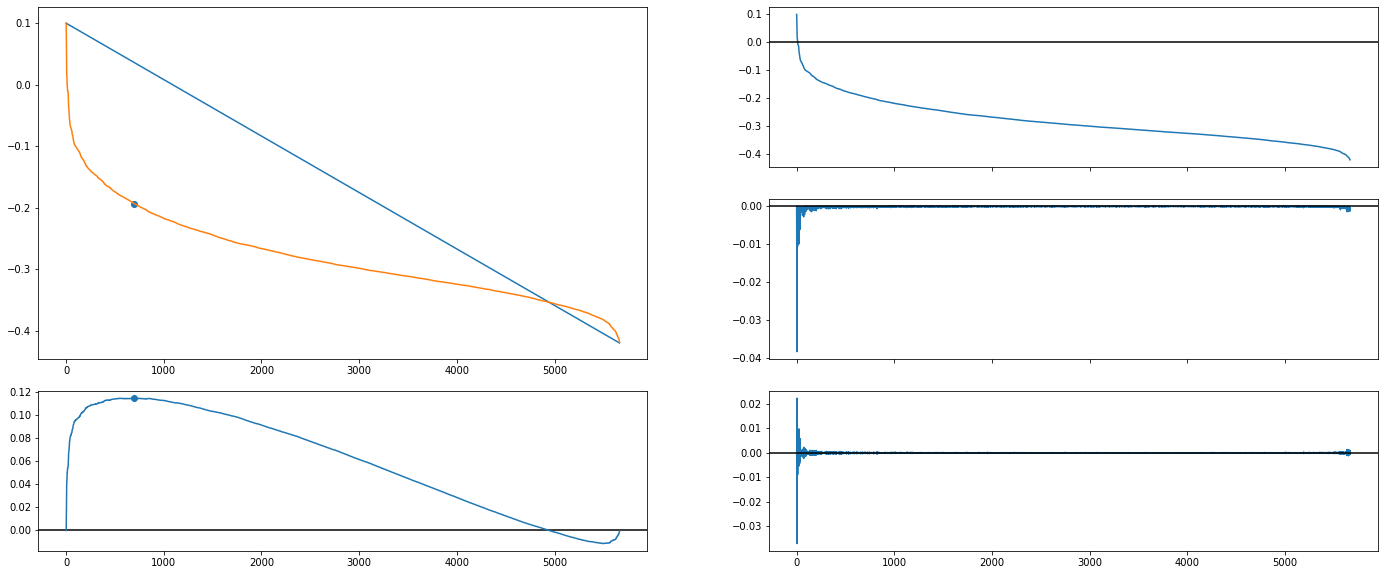

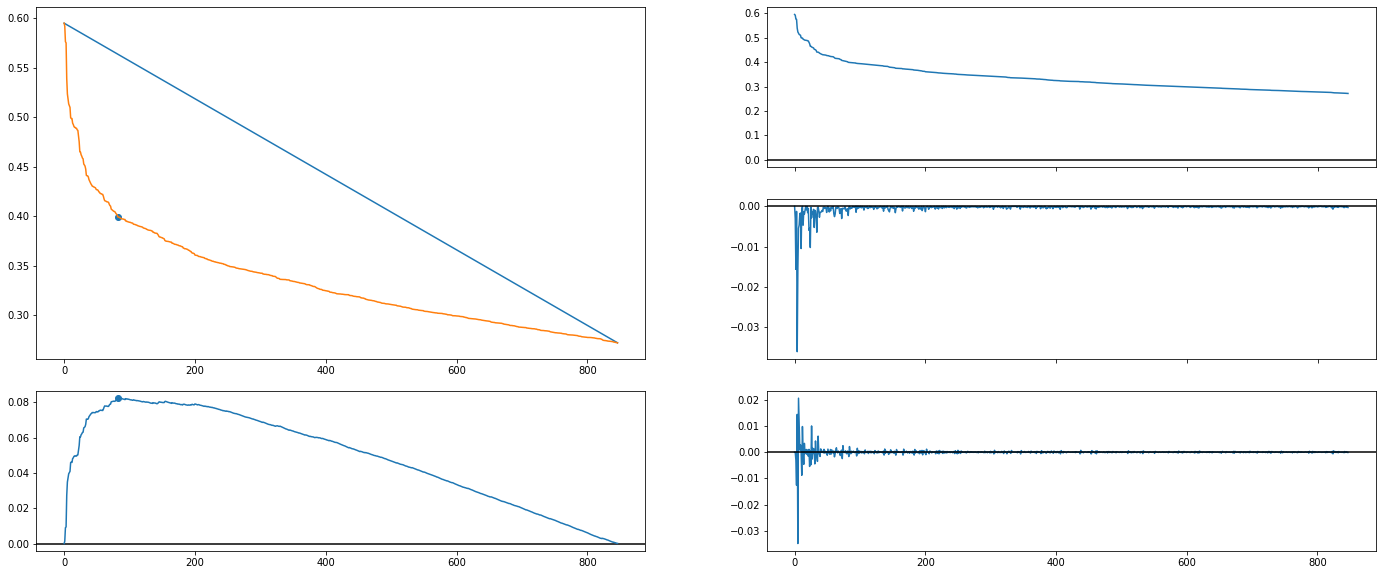

In [112]:
top_num = 10
display_limit = -1
terms, scores = topic_descriptions[top_num]
print(len(scores), " total similar terms found from raw data.")
raw_scores = (
    1
    - sklearn.metrics.pairwise_distances(
        np.array([top2vec_model.topic_vectors[top_num]]), top2vec_model.word_vectors
    )
)[0]
plot_heuristic(
    raw_scores,
    f"Topic {top_num} - Raw Cosine",
    derivatives="values",
    figsize=(24, 10),
    display_limit=display_limit,
)

# Now show what the elbow would be if you ran it twice
# Need to spcify first_elbow=False, otherwise you can run into some bad cases
elbow_twice = plot_heuristic(
    scores,
    f"Topic {top_num} - Values",
    derivatives="values",
    figsize=(24, 10),
    display_limit=display_limit,
    first_elbow=False,
)
print(f"Running heuristic twice gives {elbow_twice} terms: ", terms[:elbow_twice])

In [118]:
doc_topic_matrix = generate_similarity_matrix(
    top2vec_model.document_vectors, top2vec_model.topic_vectors, topn=topn
)
doc_topic_num_zeroes = np.count_nonzero(doc_topic_matrix == 0)
doc_topic_sparsity = doc_topic_num_zeroes / (doc_topic_matrix.size)
topic_term_matrix = generate_similarity_matrix(
    top2vec_model.topic_vectors, top2vec_model.word_vectors, topn=topn
)
topic_term_num_zeroes = np.count_nonzero(topic_term_matrix == 0)
topic_term_sparsity = topic_term_num_zeroes / (topic_term_matrix.size)

doc_topic_sparsity, topic_term_sparsity

(0.873982100534154, 0.9100264690312334)